#AI สำหรับจำแนกสมุนไพรไทยที่ใช้รักษาโรค
รายชื่อสมาชิกกลุ่ม Hayday
1. 6509490048 ภรลดา บุญธรรม
2. 6509611627 ชนินทร์ ศรีสารคาม
3. 6509611742 ธนพนธ์ ศิริวัฒน์
4. 6509611825 นิติกร คณะแพง
5. 6509611924 แพรวา สุรางค์วัฒนกุล
6. 6509612039 ศรวัณ เจริญวัฒน์

#1. Import Library and Dataset
import Libary และ dataset ที่จะใช้งานสำหรับการเทรนโมเดล


In [ ]:
!pip install tensorflow # Installs TensorFlow library
!pip install keras # Installs keras library


In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import efficientnet_v2 , NASNetMobile

import tensorflow_hub as hub
from sklearn.metrics import classification_report
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import os
from datetime import datetime

%matplotlib inline

In [ ]:
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


#2.  data preparation (การเตรียมชุดข้อมูล)
จัดการชุดข้อมูลที่รับเข้ามาให้เหมาะสมด้วยการปรับพารามิเตอร์รูปภาพก่อนการนำไปใช้


In [ ]:
train_path = "/content/gdrive/MyDrive/datasetplant/6ClassDatasetPlant/train" # @param{type:"string"}
test_path = "/content/gdrive/MyDrive/datasetplant/6ClassDatasetPlant/test" # @param{type:"string"}
valid_path = "/content/gdrive/MyDrive/datasetplant/6ClassDatasetPlant/valid" # @param{type:"string"}

In [ ]:
# @title 2.1. Set up Custom parameter Datagen { display-mode: "form" }
ROTATION_RANGE = 0 # @param {type:"number"}
HORIZONTAL_FLIP = True # @param{type:"boolean"}
VERTICAL_FLIP = True # @param{type:"boolean"}
ZOOM_RANGE = 0 # @param {type:"number"}
WIDTH_SHIFT_RANGE = 0 # @param {type:"number"}
HEIGHT_SHIFT_RANGE = 0 # @param {type:"number"}

BATCH_SIZE = 32 # @param{type:"integer"}
IMAGE_SIZE = 224 # @param{type:"integer"}





**โดย จะมีการทำ ImageDataGenerator ดังนี้**
1. Random Rotation ( สุ่มหมุนภาพ ) เป็นการกำหนดช่วงการหมุนภาพในหน่วยองศา เมื่อกำหนดค่าเริ่มต้นและสิ้นสุดของช่วงการหมุน โมเดลจะสุ่มหมุนภาพในช่วงนั้นเพื่อให้โมเดลเรียนรู้ได้ดีกว่าในสภาวะที่ภาพไม่ได้ถูกหมุน

2. Random Shifts (สุ่มเคลื่อนย้ายภาพ) เคลื่อนย้ายภาพไปในทิศทางต่างๆ อย่างสุ่มเพื่อเพิ่มความหลากหลายในชุดข้อมูลที่ใช้ในการฝึกสอนโมเดลเชิงลึก เป็นหนึ่งในเทคนิคในการเตรียมข้อมูลภาพที่มีประสิทธิภาพเพื่อป้องกันการเรียนรู้จากลักษณะเฉพาะของภาพในชุดข้อมูล

3. Random Flips (สุ่มพลิกภาพ) คือการทำการพลิกภาพในแนวนอนหรือในแนวตั้งอย่างสุ่มขณะเตรียมข้อมูลภาพสำหรับการฝึกสอนโมเดลเชิงลึก โดยมักจะใช้กับชุดข้อมูลภาพเพื่อเพิ่มความหลากหลายในการเรียนรู้ของโมเดลซึ่งช่วยลดโอกาสของการเกิดการเรียนรู้จากลักษณะของภาพที่มีเพียงแค่มุมมองหรือทิศทางการถ่ายทอด

4. Random Zoom (สุ่มซูมภาพ)คือการซูมภาพเข้าหรือซูมออกอย่างสุ่มเพื่อเตรียมข้อมูลสำหรับการฝึกสอนโมเดลเชิงลึก โดยการปรับการซูมนี้สามารถช่วยเพิ่มความหลากหลายในชุดข้อมูลและช่วยให้โมเดลมีความสามารถในการรับมือกับการเปลี่ยนแปลงขนาดของวัตถุในภาพได้

In [ ]:
# @title 2.2 Run ImageDataGenerator

train_datagen = ImageDataGenerator( width_shift_range = WIDTH_SHIFT_RANGE ,
                                   height_shift_range = HEIGHT_SHIFT_RANGE,
                                   rotation_range =  ROTATION_RANGE ,
                                   horizontal_flip =  HORIZONTAL_FLIP ,
                                   vertical_flip = VERTICAL_FLIP ,
                                   zoom_range = ZOOM_RANGE)
train_generator = train_datagen.flow_from_directory(
        directory=train_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')


test_datagen = ImageDataGenerator( width_shift_range = WIDTH_SHIFT_RANGE ,
                                   height_shift_range = HEIGHT_SHIFT_RANGE,
                                   rotation_range =  ROTATION_RANGE ,
                                   horizontal_flip =  HORIZONTAL_FLIP ,
                                   vertical_flip = VERTICAL_FLIP ,
                                   zoom_range = ZOOM_RANGE)
test_generator = test_datagen.flow_from_directory(
        directory=test_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle = False,
        class_mode='categorical')


valid_datagen = ImageDataGenerator( width_shift_range = WIDTH_SHIFT_RANGE ,
                                   height_shift_range = HEIGHT_SHIFT_RANGE,
                                   rotation_range =  ROTATION_RANGE ,
                                   horizontal_flip =  HORIZONTAL_FLIP ,
                                   vertical_flip = VERTICAL_FLIP ,
                                   zoom_range = ZOOM_RANGE)
valid_generator = valid_datagen.flow_from_directory(
        directory=valid_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle = False,
        class_mode='categorical')



Found 417 images belonging to 6 classes.
Found 58 images belonging to 6 classes.
Found 148 images belonging to 6 classes.


**ดึงค่าชื่อของแต่ละคลาสที่มีใน train_generator ในการจัดการข้อมูลสำหรับการฝึกอบรมโมเดล**

In [ ]:

class_names = train_generator.class_indices
class_names


{'Green chiretta': 0,
 'Holy Basil': 1,
 'Kaffir lime': 2,
 'Lemon balm': 3,
 'Lemon grass': 4,
 'Thai basil': 5}

**คำนวณจำนวนของคลาสในชุดข้อมูลและกำหนดค่าให้กับ CLASS_SIZE**
และทำการสุ่มให้มีลักษณะที่เหมือนกันทุกครั้ง เพื่อให้ผลลัพธ์ที่ได้มีความน่าเชื่อถือและมีความท้าทายที่มีความเหมาะสม โดยการตั้งค่า seed จะช่วยให้สามารถควบคุมความสัมพันธ์ระหว่างการสุ่มและการฝึกโมเดลได้ดีขึ้น และทำให้ผลลัพธ์มีความน่าเชื่อถือมากยิ่งขึ้น

In [ ]:
CLASS_SIZE = len(class_names)


In [ ]:
import random
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#set seed

#เลือก Model ที่นำมาใช้ Train
โดยโปรเจคของเราได้เลือก 4 โมเดลที่จะนำมาใช้นั่นคือ  MobileNetV3Small, ResNet-50, EfficientNetV2L, NasNetMobile โดยโมเดลที่มีประสิทธิภาพแม่นยำที่สุดคือ EfficientNetV2L

In [ ]:
# @title เลือก Model ที่นำมาใช้ Train
model_name = "NASNetMobile" # @param ["MobileNetV3Small", "RestNet-50", "EfficientNetV2L",  "NASNetMobile"]

In [ ]:
if model_name == "MobileNetV3Small":
  base_model = keras.applications.MobileNetV3Small(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet') # Load the MobileNetV3Small model
  base_model.trainable = True # Enable to train Pre-Trained Model
if model_name == "RestNet-50":
  base_model = ResNet50(
    input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3], # Making the image into 3 Channel, so concating 3.
    weights='imagenet', # Default weights.
    include_top=False
  )
  base_model.trainable = True # Enable to train Pre-Trained Model
if model_name == "EfficientNetV2L":
  base_model = efficientnet_v2.EfficientNetV2B0(include_top=False,
                                                input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3],
                                                weights="imagenet")

if model_name == "NASNetMobile":
  base_model = NASNetMobile(
    include_top=False,
    input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3],
    weights="imagenet"
  )


inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # Define input layer


19993432/19993432 [==============================] - 0s 0us/step


**สร้างโมเดล neural network โดยประกอบด้วยชั้นต่างๆ**

In [ ]:

x = inputs # Apply Augmentation to the input images. this use for decrease overfit
x = base_model(x, training=False) # Pass Augmentation Data to base_model
x = layers.GlobalAveragePooling2D(name="GloPool")(x) # Create Global Average Pooling and input x to get output tensor that value = Dense's filter. this use for decrease feature map
outputs = tf.keras.layers.Dense(CLASS_SIZE, activation="softmax", name="output_layer")(x) # output layer that (output unit = CLASS_SIZE as image class, activation function is softmax  )
model_0 = tf.keras.Model(inputs, outputs) # Create Model name model_0 that have input layer, base mosel, output layer
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"]) #Compile model_0 with categorical_crossentropy, adam's learning rate = 0.0001, metric by accuracy


In [ ]:
model_0.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 GloPool (GlobalAveragePool  (None, 1056)              0         
 ing2D)                                                          
                                                                 
 output_layer (Dense)        (None, 6)                 6342      
                                                                 
Total params: 4276058 (16.31 MB)
Trainable params: 4239320 (16.17 MB)
Non-trainable params: 36738 (143.51 KB)
_________________________________________________________________


ใช้ early stopping (custom_early_stopping) เพื่อหยุดการฝึกอบรมเมื่อเกิดการ
overfitting

In [ ]:
custom_early_stopping = EarlyStopping( # EarlyStopping is keras's callback function that stop training model before overfitting
    monitor='val_loss', # monitor at validation loss
    patience=10,
    min_delta=0.000000001, # if validation loss is not decrease at least 0.001 in 10 time
    mode='min' # need validtion loss to decrease
)

#Train Model
เทรนโมเดลโดยใช้ชุดข้อมูลจาก train_generator และมีรอบการ train อยู่ที่ 30 รอบ  

In [ ]:
start = datetime.now()

history = model_0.fit(train_generator, # Use from train generator
           epochs=30, # training round
           workers=0,
           steps_per_epoch=len(train_generator), # Use from batch size that can update each epoch for training
           validation_data=valid_generator, # Use from test generator
           validation_steps=len(valid_generator),
           callbacks=[custom_early_stopping]) # Stop training when overfitting

print ('Execution Time: ',datetime.now()-start)


Epoch 1/30
14/14 [==============================] - 316s 15s/step - loss: 2.2432 - accuracy: 0.2278 - val_loss: 1.9535 - val_accuracy: 0.1622
Epoch 2/30
14/14 [==============================] - 161s 12s/step - loss: 1.6442 - accuracy: 0.2926 - val_loss: 1.6138 - val_accuracy: 0.2568
Epoch 3/30
14/14 [==============================] - 151s 11s/step - loss: 1.3180 - accuracy: 0.4317 - val_loss: 1.1274 - val_accuracy: 0.5338
Epoch 4/30
14/14 [==============================] - 159s 11s/step - loss: 1.1523 - accuracy: 0.5252 - val_loss: 0.8835 - val_accuracy: 0.6554
Epoch 5/30
14/14 [==============================] - 163s 12s/step - loss: 1.1091 - accuracy: 0.5372 - val_loss: 1.1216 - val_accuracy: 0.5608
Epoch 6/30
14/14 [==============================] - 158s 11s/step - loss: 0.9990 - accuracy: 0.6091 - val_loss: 0.8075 - val_accuracy: 0.6284
Epoch 7/30
14/14 [==============================] - 152s 11s/step - loss: 1.2527 - accuracy: 0.5036 - val_loss: 1.4879 - val_accuracy: 0.3378
Epoch 

In [ ]:
#@title 3.2. Evaluate the model on the test set
test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

<ipython-input-16-74d96c32e9dc>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))


Test loss: 2.2934465408325195
Test accuracy: 0.5517241358757019


แสดงค่าความสูญเสีย, ค่าความแม่นยำของโมเดล และระยะเวลาที่ใช้ประเมินผลโมเดล

In [ ]:
# Evaluate the model on the test set
start = datetime.now()
test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test Time:',datetime.now()-start)


<ipython-input-17-0897c54d69da>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))


Test loss: 2.465542793273926
Test accuracy: 0.5862069129943848
Test Time: 0:00:04.816095


Evaluate Model (สรุปผลโมเดล)
โดยใช้วิธีการวัดผลคือการทำ Confusion Matrix และคำนวณค่าความแม่นยำ (precision), ความละเอียด (recall), และF1 score เพื่อประเมินความสามารถของโมเดลในการแยกแยะคลาสต่าง ๆ ของข้อมูล

2/2 [==============================] - 3s 332ms/step


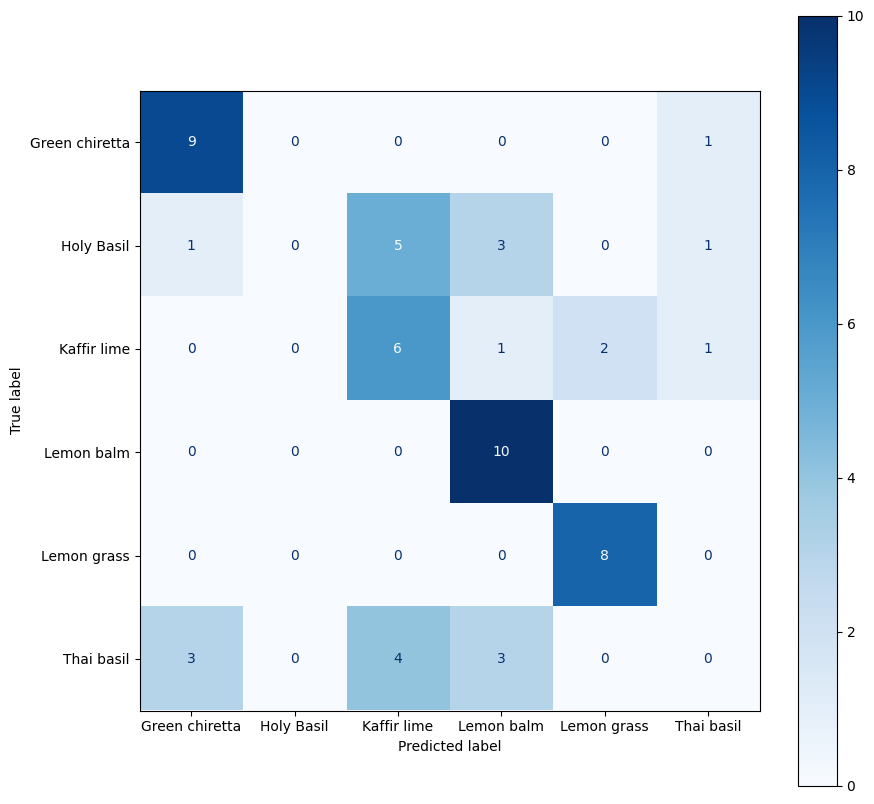

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,class,specificity,sensitivity
0,0,0.916667,0.9
1,1,1.000000,0.0
2,2,0.812500,0.6
3,3,0.854167,1.0
4,4,0.960000,1.0
5,5,0.937500,0.0


In [ ]:
import sklearn as scikit_learn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

test_true=test_generator.classes[test_generator.index_array]
test_pred_raw = model_0.predict(test_generator)
test_pred = np.argmax(test_pred_raw, axis=1)

cm = confusion_matrix(test_true, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()


res = []
for l in range(CLASS_SIZE):
    pres,recall,_,_ = precision_recall_fscore_support(np.array(test_true)==l,np.array(test_pred)==l,pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','specificity','sensitivity'])


สร้างผลรายงานการจำแนกประเภท (classification report) สำหรับผลลัพธ์การทำนายของโมเดล

In [ ]:
from sklearn.metrics import classification_report


report = classification_report(test_true, test_pred, target_names=class_names)
print(report)


                precision    recall  f1-score   support

Green chiretta       0.69      0.90      0.78        10
    Holy Basil       0.00      0.00      0.00        10
   Kaffir lime       0.40      0.60      0.48        10
    Lemon balm       0.59      1.00      0.74        10
   Lemon grass       0.80      1.00      0.89         8
    Thai basil       0.00      0.00      0.00        10

      accuracy                           0.57        58
     macro avg       0.41      0.58      0.48        58
  weighted avg       0.40      0.57      0.47        58



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ทำการวิเคราะห์และแสดงผลการ Train ของโมเดลผ่านการสร้างกราฟ โดยจะแสดงความแม่นยำและการสูญเสีย (loss) ทั้งในระหว่างการ Train และการตรวจสอบความถูกต้อง (validation)

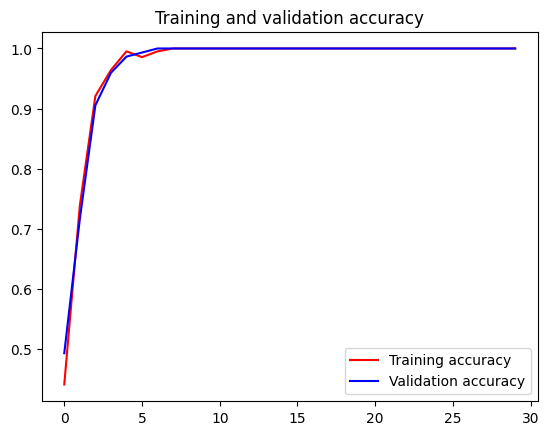

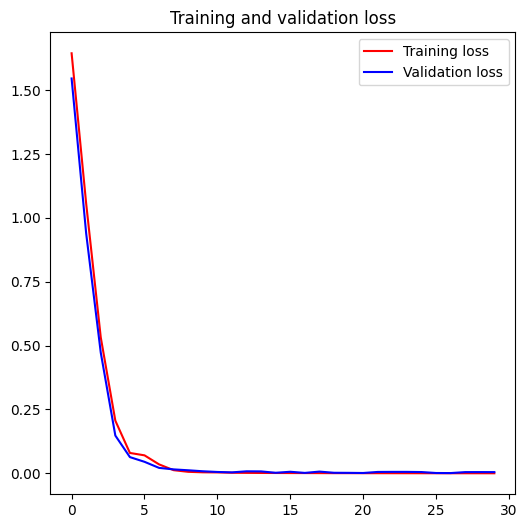

<Figure size 600x600 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure(figsize=(6,6))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure(figsize=(6,6))
p
lt.show()


หลังจาก Train Model เสร็จ save model ที่ได้เป็นไฟล์ h.5 ไปยัง gdrive  เพื่อนำไปใช้งานต่อ

In [ ]:
# Save the trained model to a .h5 file
model_0.save('/content/gdrive/MyDrive/datasetplant/model/trainedmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


โหลดโมเดล Keras จากไฟล์ .h5 และแปลงโมเดลนั้นเป็นรูปแบบ .tflite ซึ่งเป็นรูปแบบโมเดลขนาดเบาของ TensorFlow

In [ ]:
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/datasetplant/model/trainedmodel.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
tflite_model = converter.convert()
open("/content/gdrive/MyDrive/datasetplant/model/tflitemodel.tflite", "wb").write(tflite_model)


1120488

ให้สามารถอัปโหลดไฟล์ภาพจากคอมพิวเตอร์ ขึ้นสู่ Colab และแปลงไฟล์ภาพนั้นเป็นภาพในรูปแบบ OpenCV เพื่อให้สามารถนำภาพไปใช้กับโมเดลต่อได้

In [ ]:
# Upload image file
from google.colab import files
uploaded = files.upload()

# Iterate through uploaded files
for filename, file_content in uploaded.items():
    print('User uploaded file "{name}" with length {length} bytes'.format(
          name=filename, length=len(file_content)))

# Convert file content to OpenCV image
    nparr = np.frombuffer(file_content, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

Saving กะเพรา-1000x523.png to กะเพรา-1000x523.png
User uploaded file "กะเพรา-1000x523.png" with length 810285 bytes


การครอป (crop) หรือตัดภาพที่ใส่เข้ามาเพื่อให้ได้พื้นที่กลางภาพในขนาดที่กำหนด จากนั้นแสดงภาพต้นฉบับและภาพที่ถูกครอปแล้ว และบันทึกภาพที่ครอปลงใน Google drive เพื่อใช้งานต่อ



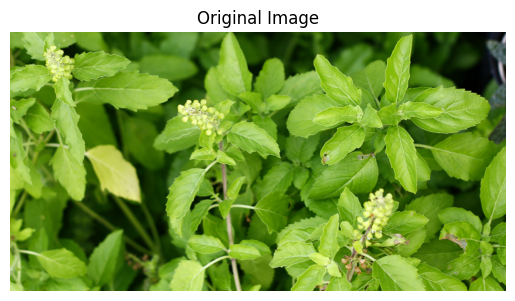

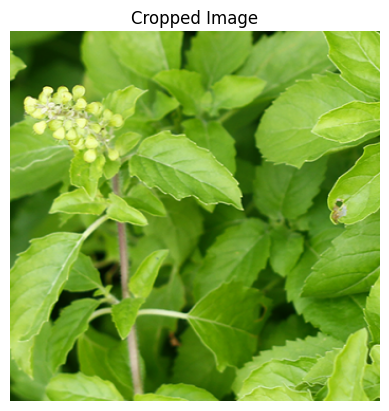

True

In [ ]:
    # Get dimensions of the image
    height, width, _ = img.shape

    # Define the dimensions of the middle portion you want to crop
    crop_width = 350   # Width of the cropped region
    crop_height = 350  # Height of the cropped region

    # Calculate the starting coordinates for the middle portion
    x = (width - crop_width) // 2
    y = (height - crop_height) // 2

    # Crop the image
    cropped_image = img[y:y+crop_height, x:x+crop_width]

    # Display the original and cropped images
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.title('Cropped Image')
    plt.axis('off')
    plt.show()

    # Save the cropped image
    cv2.imwrite('/content/gdrive/My Drive/cropped.jpg', cropped_image)

โหลดภาพที่ครอปแล้วทำการทำนายด้วยโมเดล จากนั้นทำการทำนายคลาสของภาพและแสดงผลการทำนาย

1/1 [==============================] - 0s 37ms/step
Image name: กะเพรา-1000x523.png
Predicted class: Lemon balm (99.23%)
Prediction:  ['0.03%', '0.02%', '0.01%', '99.23%', '0.00%', '0.72%']


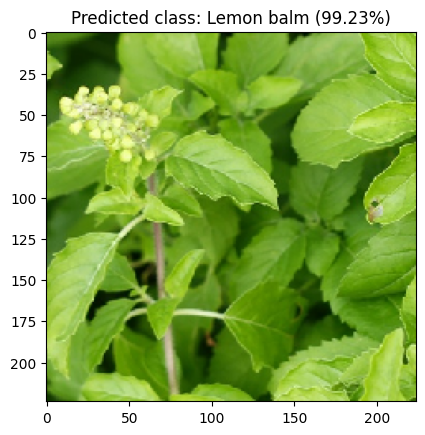

In [ ]:
# Load the cropped image
cropped_img_path = '/content/gdrive/My Drive/cropped.jpg'  # Update this path with the path where you saved the cropped image
img = image.load_img(cropped_img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)

# Make prediction
prediction = model.predict(img_array)
class_names = train_generator.class_indices
class_names = {v: k for k, v in class_names.items()} # reverse the class_indices dictionary
predicted_class = np.argmax(prediction, axis=1)
predicted_class_name = class_names[predicted_class[0]]
predicted_prob = np.max(prediction, axis=1)

# Print the result
print("Image name:", filename)
print("Predicted class: {} ({:.2f}%)".format(predicted_class_name, predicted_prob[0]*100))
prediction_list = prediction.tolist() # Convert the NumPy array to a Python list
prediction_formatted = ["{:.2%}".format(p) for p in prediction_list[0]]
print("Prediction: ", prediction_formatted)
plt.imshow(img)
plt.title("Predicted class: {} ({:.2f}%)".format(predicted_class_name, predicted_prob[0]*100))
plt.show()
print("\n")
